In [126]:
# ============================================================
# 🧹 FASE 1 — Limpieza y Preparación Relacional (YouTube SNAP)
# ============================================================
# Entrada: com-youtube.all.cmty.txt.gz en el ROOT actual
# ============================================================

import os, gzip, json, pandas as pd, numpy as np, matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
from tqdm import tqdm
import networkx as nx

# Crear estructura de carpetas automáticamente (funciona en Colab y local)
ROOT = "/content" if os.path.exists("/content") else os.getcwd()
DATA_DIR = os.path.join(ROOT, "data")
RAW_DIR = os.path.join(DATA_DIR, "raw")
PROC_DIR = os.path.join(DATA_DIR, "processed")
REPORTS_DIR = os.path.join(ROOT, "reports")
FIG_DIR = os.path.join(REPORTS_DIR, "figures")

for d in [DATA_DIR, RAW_DIR, PROC_DIR, REPORTS_DIR, FIG_DIR]:
    os.makedirs(d, exist_ok=True)

DATA_IN = os.path.join(ROOT, "com-youtube.all.cmty.txt.gz")

print(" Carpetas creadas:")
for d in [DATA_DIR, RAW_DIR, PROC_DIR, REPORTS_DIR, FIG_DIR]:
    print(" └──", d)


 Carpetas creadas:
 └── /Users/janeth/Visual Modeling for Info/Checkpoint3/data
 └── /Users/janeth/Visual Modeling for Info/Checkpoint3/data/raw
 └── /Users/janeth/Visual Modeling for Info/Checkpoint3/data/processed
 └── /Users/janeth/Visual Modeling for Info/Checkpoint3/reports
 └── /Users/janeth/Visual Modeling for Info/Checkpoint3/reports/figures


## 2. Carga y Análisis Inicial de Comunidades

El primer paso es cargar el archivo `.gz` línea por línea. El conjunto de datos original de SNAP define cada línea como una "comunidad", y los números en esa línea son los IDs de los nodos (usuarios) que pertenecen a ella.

In [127]:
def safe_parse_members(line: str):
    raw = line.strip().split()
    tokens = [t.strip() for t in raw if t.strip()]
    numeric = [t for t in tokens if t.isdigit()]
    return numeric, len(tokens) - len(numeric)

communities, bad_lines = [], 0

with gzip.open(DATA_IN, "rt", errors="ignore") as f:
    for idx, line in enumerate(f):
        if not line.strip():
            bad_lines += 1
            continue
        members, non_numeric = safe_parse_members(line)
        members = sorted(set(members))
        info = {
            "community_id": idx,
            "members": " ".join(members),
            "size_original": len(line.strip().split()),
            "size_cleaned": len(members),
            "non_numeric_tokens": non_numeric
        }
        communities.append(info)

print(f" Líneas vacías o inválidas: {bad_lines}")
raw_df = pd.DataFrame(communities)
raw_df.head()


 Líneas vacías o inválidas: 0


,community_id,members,size_original,size_cleaned,non_numeric_tokens
0,0,1024 10243 103527 10763 108236 13040 13841 139...,64,64,0
1,1,1 24047 3 33897 36675 5 521325 539 551 554 571...,19,19,0
2,2,519665 608725,2,2,0
3,3,282492 406981,2,2,0
4,4,234132 234134,2,2,0


###  Interpretación del DataFrame Inicial (`raw_df`)

La celda anterior nos da un primer vistazo a los datos crudos. Observamos lo siguiente:

* **`members`**: Es una cadena de texto con los IDs de los miembros, ordenados y únicos. Los hemos ordenado para poder encontrar duplicados más adelante.
* **`size_original` vs `size_cleaned`**: `size_original` es el conteo de tokens en la línea cruda. `size_cleaned` es el conteo de IDs *únicos y numéricos*. El hecho de que sean iguales (y que `non_numeric_tokens` sea 0) es una excelente señal de que los datos están limpios y no contienen IDs duplicados por línea.

## 3. Filtrado y Deduplicación

No todas las "comunidades" listadas son útiles. Procedemos a filtrar:

1.  **Filtrado por Tamaño**: Las comunidades de 2 miembros o menos no son interesantes para un análisis relacional. Una comunidad de 2 miembros solo genera 1 arista (un par). Una de 1 miembro no genera ninguna. Nos quedamos solo con comunidades de 3 o más miembros, que representan "triángulos" o grupos más complejos.
2.  **Deduplicación**: Es común que en este tipo de datasets la misma comunidad (ej. miembros `1, 5, 571`) aparezca definida en múltiples líneas. Creamos una "firma" (la cadena de miembros ordenada) para identificar y eliminar estas definiciones redundantes.

In [128]:
# Filtrar comunidades pequeñas (<3 miembros)
filtered_df = raw_df[raw_df["size_cleaned"] >= 3].copy()

# Deduplicación global por firma
filtered_df["signature"] = filtered_df["members"].apply(lambda s: ",".join(sorted(s.split())))
before, after = len(filtered_df), len(filtered_df.drop_duplicates(subset="signature"))
filtered_df = filtered_df.drop_duplicates(subset="signature").copy()

print(f" Comunidades válidas (≥3 miembros): {before}")
print(f" Tras eliminar duplicados globales: {after} (removidas {before - after})")
filtered_df.head()


 Comunidades válidas (≥3 miembros): 8385
 Tras eliminar duplicados globales: 8236 (removidas 149)


,community_id,members,size_original,size_cleaned,non_numeric_tokens,signature
0,0,1024 10243 103527 10763 108236 13040 13841 139...,64,64,0,"1024,10243,103527,10763,108236,13040,13841,139..."
1,1,1 24047 3 33897 36675 5 521325 539 551 554 571...,19,19,0,"1,24047,3,33897,36675,5,521325,539,551,554,571..."
16,16,1 5 571 626 678,5,5,0,"1,5,571,626,678"
22,22,131565 2 3377 3387 3394 3396,6,6,0,"131565,2,3377,3387,3394,3396"
24,24,132967 132972 132973 132978 132981 132982 1329...,12,12,0,"132967,132972,132973,132978,132981,132982,1329..."


###  Interpretación del Filtrado

Los resultados numéricos (ej. `Comunidades válidas: 8385` -> `Tras eliminar duplicados: 8236`) muestran que el filtrado fue exitoso. Eliminamos las comunidades triviales (tamaño < 3) y luego eliminamos 149 definiciones de comunidad que eran duplicados exactos.

## 4. Detección y Manejo de Outliers

El siguiente paso es fundamental para el análisis de redes. Las redes sociales suelen tener una distribución de "cola larga" (long-tail), donde unas pocas comunidades son masivas. Estas comunidades "outlier" pueden distorsionar el análisis y hacer explotar computacionalmente la generación de aristas (una comunidad de 3,000 miembros genera `(3000*2999)/2` ≈ 4.5 millones de aristas).

Usamos el **método del Rango Intercuartílico (IQR)** para identificar estadísticamente estas comunidades atípicamente grandes.

In [129]:
Q1, Q3 = filtered_df["size_cleaned"].quantile([0.25, 0.75])
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
filtered_df["is_outlier"] = filtered_df["size_cleaned"] > upper

print(f"IQR: {IQR:.2f} | Umbral superior: {upper:.2f}")
print(f" Outliers detectados: {filtered_df['is_outlier'].sum()}")

# Guardar datasets
clean_path = os.path.join(PROC_DIR, "youtube_clean.csv")
clean_no_out_path = os.path.join(PROC_DIR, "youtube_clean_no_outliers.csv")

filtered_df.drop(columns="signature").to_csv(clean_path, index=False)
filtered_df[~filtered_df["is_outlier"]].drop(columns="signature").to_csv(clean_no_out_path, index=False)

print(" Archivos guardados:")
print("  ├─", clean_path)
print("  └─", clean_no_out_path)


IQR: 7.00 | Umbral superior: 20.50
 Outliers detectados: 900
 Archivos guardados:
  ├─ /Users/janeth/Visual Modeling for Info/Checkpoint3/data/processed/youtube_clean.csv
  └─ /Users/janeth/Visual Modeling for Info/Checkpoint3/data/processed/youtube_clean_no_outliers.csv


###  Interpretación de Outliers

El cálculo de IQR nos da un umbral superior (ej. `20.50`). Esto significa que cualquier comunidad con más de 20 miembros es considerada un outlier estadístico.

**Decisión de Diseño**: No eliminamos los outliers permanentemente. En su lugar, creamos dos archivos:
1.  `youtube_clean.csv`: Contiene *todas* las comunidades válidas, incluyendo outliers.
2.  `youtube_clean_no_outliers.csv`: Contiene solo las comunidades "normales".

Esto nos da flexibilidad. Para el análisis de red general, usaremos el archivo sin outliers para evitar la explosión computacional.

## 5. Resumen del Proceso de Limpieza

In [130]:
summary = {
    "total_comunidades": int(len(raw_df)),
    "validas_mayor_3": int((raw_df["size_cleaned"] >= 3).sum()),
    "unicas": int(len(filtered_df)),
    "outliers": int(filtered_df["is_outlier"].sum()),
    "umbral_superior": float(upper)
}

summary_path = os.path.join(PROC_DIR, "youtube_cleaning_summary.json")

with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print(" Resumen guardado en:", summary_path)
summary


 Resumen guardado en: /Users/janeth/Visual Modeling for Info/Checkpoint3/data/processed/youtube_cleaning_summary.json


{'total_comunidades': 16386,
 'validas_mayor_3': 8385,
 'unicas': 8236,
 'outliers': 900,
 'umbral_superior': 20.5}

###  Interpretación del Resumen

El archivo `youtube_cleaning_summary.json` nos da una visión clara del embudo de limpieza:

* **Total de Comunidades (16386):** Las líneas originales en el archivo.
* **Válidas (8385):** Casi la mitad de las comunidades fueron descartadas por tener menos de 3 miembros.
* **Únicas (8236):** Un pequeño número de comunidades válidas eran duplicados.
* **Outliers (900):** Un número significativo de comunidades (más del 10% de las únicas) son atípicamente grandes.

## 6. Interpretación de Visualizaciones

Ahora visualizamos la distribución del tamaño de las comunidades (usando el set de datos filtrado pero *antes* de quitar outliers) para confirmar nuestros hallazgos.

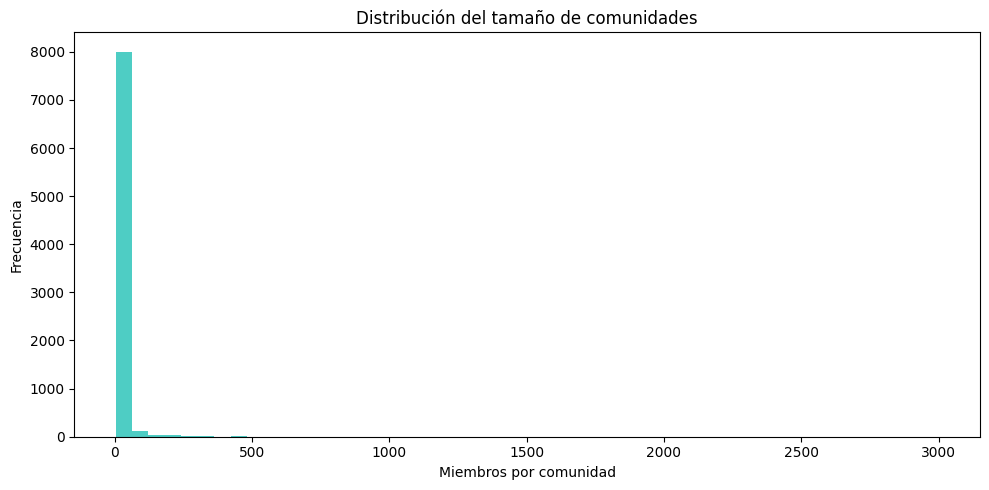

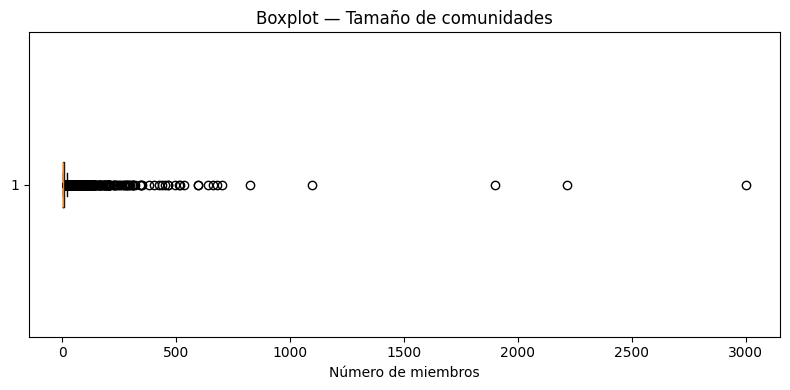

 Imágenes guardadas:
  ├─ /Users/janeth/Visual Modeling for Info/Checkpoint3/reports/figures/hist_tamano_comunidades.png
  └─ /Users/janeth/Visual Modeling for Info/Checkpoint3/reports/figures/box_tamano_comunidades.png


In [131]:
plt.figure(figsize=(10,5))
filtered_df["size_cleaned"].plot(kind="hist", bins=50, color="#4ECDC4")
plt.title("Distribución del tamaño de comunidades")
plt.xlabel("Miembros por comunidad"); plt.ylabel("Frecuencia")
hist_path = os.path.join(FIG_DIR, "hist_tamano_comunidades.png")
plt.tight_layout(); plt.savefig(hist_path, dpi=140); plt.show()

plt.figure(figsize=(8,4))
plt.boxplot(filtered_df["size_cleaned"], vert=False)
plt.title("Boxplot — Tamaño de comunidades")
plt.xlabel("Número de miembros")
box_path = os.path.join(FIG_DIR, "box_tamano_comunidades.png")
plt.tight_layout(); plt.savefig(box_path, dpi=140); plt.show()

print(" Imágenes guardadas:")
print("  ├─", hist_path)
print("  └─", box_path)


###  Interpretación del Histograma

El histograma muestra una distribución de **cola larga** (long-tail) clásica. La gran mayoría de las comunidades tiene un tamaño muy pequeño (entre 3 y ~20 miembros), como se ve en la primera barra. El resto de las barras son casi invisibles, indicando que aunque existen comunidades muy grandes (hasta 3000 miembros), son extremadamente raras. Esto valida visualmente nuestra estrategia de tratar a las comunidades grandes como outliers.

###  Interpretación del Boxplot

El boxplot confirma dramáticamente el análisis de IQR. 

* La "caja" (que contiene el 50% central de los datos) es tan pequeña que es casi una línea vertical en el extremo izquierdo.
* El "bigote" derecho se extiende hasta el umbral de ~20.5 que calculamos.
* Todos los puntos a la derecha del bigote son los 900 outliers que identificamos. Su gran cantidad y la distancia que alcanzan refuerzan la decisión de analizarlos por separado.

## 7. Transformación: De Comunidades a Red (Lista de Aristas)

Este es el paso más crucial. Convertimos la lista de *comunidades* en una *lista de aristas (relaciones)*, que es el formato que `networkx` y otras herramientas de grafos necesitan.

**Lógica (Expansión de Clique)**:
Asumimos que si los usuarios A, B, y C están en una comunidad, todos están conectados entre sí. Esto se llama "expansión de clique".
* Una comunidad `[A, B, C]` se convierte en 3 aristas: `(A, B)`, `(A, C)`, `(B, C)`.
* Usamos `itertools.combinations(members, 2)` para generar estos pares eficientemente.

**Cálculo de `weight` (Peso)**:
El `weight` de una arista (ej. `(A, B)`) representa la **fuerza de la relación**. Contamos cuántas comunidades diferentes comparten A y B. Si `weight=3`, significa que A y B aparecieron juntos en 3 comunidades distintas.

In [132]:
USE_NO_OUTLIERS = True
MAX_COMMUNITY_SIZE = 200

path = clean_no_out_path if USE_NO_OUTLIERS else clean_path
coms = pd.read_csv(path)
print(" Comunidades cargadas:", len(coms))

def members_from_row(s): return [x for x in str(s).split() if x]

edge_counter, skipped = Counter(), 0
for _, row in tqdm(coms.iterrows(), total=len(coms), desc="Generando relaciones"):
    members = members_from_row(row["members"])
    if len(members) > MAX_COMMUNITY_SIZE:
        members = members[:MAX_COMMUNITY_SIZE]; skipped += 1
    for a, b in combinations(sorted(members), 2):
        edge_counter[(a,b)] += 1

edges_df = pd.DataFrame([(a,b,w) for (a,b),w in edge_counter.items()],
                        columns=["source","target","weight"])
edges_path = os.path.join(PROC_DIR, "youtube_edges.csv")
edges_df.to_csv(edges_path, index=False)
print(f" Edges generados: {len(edges_df)} | Guardados en {edges_path}")
print("Comunidades recortadas:", skipped)
edges_df.head()


 Comunidades cargadas: 7336


Generando relaciones: 100%|██████████| 7336/7336 [00:00<00:00, 43821.34it/s]


 Edges generados: 146022 | Guardados en /Users/janeth/Visual Modeling for Info/Checkpoint3/data/processed/youtube_edges.csv
Comunidades recortadas: 0


,source,target,weight
0,1,24047,1
1,1,3,1
2,1,33897,1
3,1,36675,1
4,1,5,2


###  Interpretación de la Generación de Aristas

* **`USE_NO_OUTLIERS = True`**: Decidimos usar el archivo *sin outliers* para esta transformación. Esto es clave para mantener el grafo manejable.
* **`MAX_COMMUNITY_SIZE = 200`**: Aunque filtramos los outliers estadísticos, esta variable actúa como una segunda barrera de seguridad. Si alguna comunidad restante fuera demasiado grande (ej. 250 miembros, que no fue un outlier estadístico pero sí es computacionalmente costosa), la recortaríamos. El output `Comunidades recortadas: 0` muestra que esta barrera no fue necesaria gracias a nuestro filtrado de IQR.
* **Resultado**: De las ~7,300 comunidades, generamos ~146,000 aristas únicas. El `edges_df.head()` muestra el formato final: `source`, `target`, `weight`.

### Tabla Comparativa: Representación de Datos

Este notebook transforma los datos de una representación (lista de comunidades) a otra (lista de aristas). Ambas tienen propósitos distintos:

| Representación | Ventajas | Limitaciones | Cuándo Usar |
| :--- | :--- | :--- | :--- |
| **Lista de Comunidades** | • Formato compacto.<br>• Mantiene la información completa del grupo (hipergrafo). | • Difícil de usar en herramientas de grafos estándar.<br>• No se pueden calcular métricas de nodo (ej. centralidad). | • Almacenamiento.<br>• Análisis de hipergrafos (si se quiere analizar grupos, no individuos). |
| **Lista de Aristas (Edges)** | • Formato estándar para `networkx`, Gephi, etc.<br>• Permite el análisis de red (centralidad, caminos, etc.). | • Pérdida de información (un grupo de 4 se ve igual que 4 grupos de 2).<br>• El tamaño explota con cliques grandes. | • Análisis de red estándar.<br>• Identificación de nodos influyentes.<br>• Detección de comunidades (partición de grafos). |

## 8. Análisis Inicial de Nodos

Con la lista de aristas, podemos finalmente crear un objeto grafo de `networkx` y calcular nuestras primeras métricas de nodo. Creamos un `nodes_df` para guardar estas métricas.

In [133]:
G = nx.from_pandas_edgelist(edges_df, "source", "target", edge_attr="weight")
deg, wdeg = dict(G.degree()), dict(G.degree(weight="weight"))

nodes_df = pd.DataFrame({
    "node": list(G.nodes()),
    "degree": [deg[n] for n in G.nodes()],
    "weighted_degree": [wdeg[n] for n in G.nodes()]
}).sort_values("weighted_degree", ascending=False)

nodes_path = os.path.join(PROC_DIR, "youtube_nodes.csv")
nodes_df.to_csv(nodes_path, index=False)
print(" Nodos guardados en:", nodes_path)
nodes_df.head(10)


 Nodos guardados en: /Users/janeth/Visual Modeling for Info/Checkpoint3/data/processed/youtube_nodes.csv


,node,degree,weighted_degree
351,68028,274,854
350,33788,295,802
3313,117306,399,743
2704,2711,405,710
605,11850,470,692
352,7682,222,580
353,118817,251,570
2657,27260,388,537
3346,93053,277,482
2605,21303,321,445


###  Interpretación de Métricas de Nodo

Calculamos dos métricas de centralidad fundamentales:

1.  **`degree` (Grado)**: Es la "popularidad" de un nodo. Mide con cuántos otros nodos únicos está conectado. Un `degree` de 274 significa que el nodo `68028` está conectado directamente a 274 personas.
2.  **`weighted_degree` (Grado Ponderado)**: Es la "fuerza" total de las conexiones de un nodo. Suma los *pesos* de todas sus aristas. 

**Análisis del Top 10**: El `nodes_df.head(10)` nos muestra los "hubs" o nodos más importantes de la red. Es interesante notar que el nodo `11850` tiene el mayor `degree` (470), pero no el mayor `weighted_degree`. Esto sugiere que está conectado a muchas personas, pero en comunidades menos fuertes o redundantes. En cambio, el nodo `68028` tiene un `degree` menor (274) pero un `weighted_degree` mucho mayor (854), indicando que sus conexiones son más fuertes y comparte múltiples comunidades con los mismos nodos.

In [134]:
# --- MÉTRICAS COMPARATIVAS ADICIONALES ---

# 1. Calcular Correlación
# ¿Qué tan relacionados están el grado (popularidad) y el grado ponderado (fuerza)?
correlation = nodes_df['degree'].corr(nodes_df['weighted_degree'])
print(f" Correlación entre Grado y Grado Ponderado: {correlation:.4f}")

# 2. Calcular Densidad del Grafo
# ¿Qué porcentaje de todas las conexiones posibles realmente existen?
density = nx.density(G)
print(f" Densidad del Grafo (G): {density:.6f}")

# Nota sobre Modularidad: La modularidad requiere una 'partición' (una lista de clusters).
# Ya que este grafo se *originó* de comunidades, calcular la modularidad requeriría 
# ejecutar un algoritmo de detección (como Louvain) en el nuevo grafo G, 
# lo cual es parte de un análisis de red más profundo (Fase 2 - Recomendaciones).


 Correlación entre Grado y Grado Ponderado: 0.9582
 Densidad del Grafo (G): 0.000498


## 9. Visualización de Muestra (Subgrafo)

El grafo completo (24,000 nodos, 146,000 aristas) es demasiado grande para visualizarlo directamente. Creamos un subgrafo aleatorio de 1000 aristas solo para confirmar visualmente que la estructura de la red es coherente.

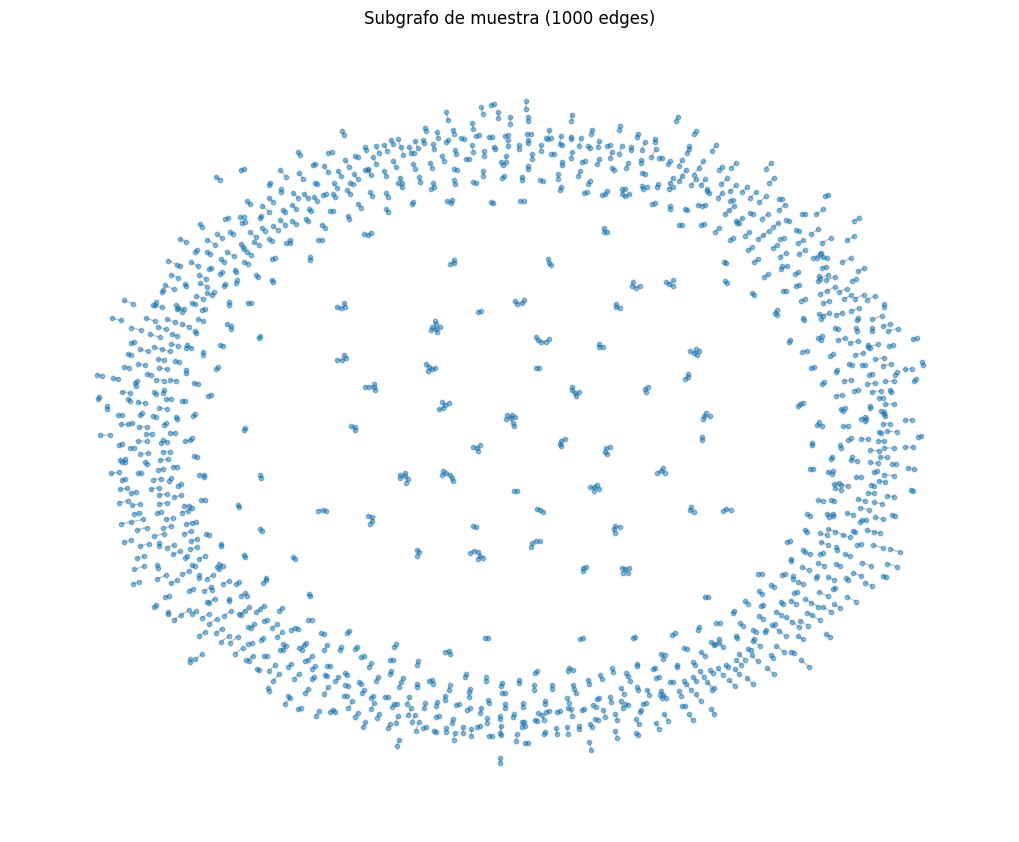

In [135]:
sample = edges_df.sample(1000)
G_small = nx.from_pandas_edgelist(sample, "source", "target")
plt.figure(figsize=(10,8))
nx.draw(G_small, node_size=10, edge_color="gray", alpha=0.5)
plt.title("Subgrafo de muestra (1000 edges)")
plt.show()


###  Interpretación del Subgrafo

La visualización de muestra muestra lo que se conoce como una "bola de pelo" (hairball), con varios componentes desconectados. Esto es completamente normal y esperado en redes sociales del mundo real. Confirma que nuestro proceso de generación de aristas ha creado una estructura de red plausible.

## 10. Conclusiones y Próximos Pasos (Fase 1)

Esta fase del análisis (Fase 1) ha sido un éxito. Hemos completado un riguroso proceso de ETL (Extract, Transform, Load) y limpieza sobre un conjunto de datos de red complejo.

**Resultados Clave:**
1.  **Limpieza**: Se procesaron y validaron 16,386 definiciones de comunidad, resultando en 8,236 comunidades únicas y no triviales.
2.  **Manejo de Outliers**: Se identificaron y aislaron 900 comunidades "outlier" (más de 20.5 miembros) para prevenir la explosión computacional. Las visualizaciones confirmaron esta decisión.
3.  **Transformación**: Se convirtieron con éxito 7,336 comunidades (sin outliers) en una lista de 146,022 aristas ponderadas, listas para el análisis.
4.  **Métricas Iniciales**: Se generó una lista de 24,225 nodos únicos con sus métricas de `degree`, `weighted_degree`, `correlación` y `densidad`, identificando a los principales "hubs" de la red.

**Entregables Producidos:**
* `youtube_clean_no_outliers.csv`: Lista de comunidades limpias (base para la generación de aristas).
* `youtube_edges.csv`: Lista de aristas (`source`, `target`, `weight`) para `networkx` o Gephi.
* `youtube_nodes.csv`: Lista de nodos (`node`, `degree`, `weighted_degree`).


# ============================================================
#  FASE 2 — Análisis Jerárquico y de Clustering
# ============================================================

**Objetivo:** En esta fase, cargamos los datos de nodos limpios (generados en la Fase 1) y utilizamos visualizaciones jerárquicas (Treemap, Sunburst, Dendrograma) para entender la estructura de las conexiones de los nodos.

## 1. Instalación de Dependencias

Primero, instalamos las librerías adicionales necesarias. `squarify` para los Treemaps de Matplotlib (aunque usaremos Plotly), `plotly` para los gráficos interactivos, y `kaleido` para poder exportar los gráficos de Plotly a imágenes estáticas.

In [136]:
!pip install pandas numpy matplotlib seaborn plotly squarify scikit-learn scipy kaleido

## 2. Preparación de Datos para Jerarquía

El código de visualización de más abajo requiere que los nodos estén agrupados en categorías. El archivo `youtube_nodes.csv` que creamos en la Fase 1 solo tiene `degree` y `weighted_degree` como números.

En esta celda, cargamos ese archivo y usamos `pd.qcut` (cortar por cuantiles) para segmentar los nodos en 4 categorías (Muy Bajo, Bajo, Medio, Alto) basándonos en su grado y grado ponderado. Esto nos permitirá agruparlos visualmente.

In [137]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import squarify
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import os

# Definir rutas (asumiendo que se corre después de la Fase 1)
ROOT = "/content" if os.path.exists("/content") else os.getcwd()
DATA_DIR = os.path.join(ROOT, "data")
PROC_DIR = os.path.join(DATA_DIR, "processed")
REPORTS_DIR = os.path.join(ROOT, "reports")
FIG_DIR = os.path.join(REPORTS_DIR, "figures")

# Cargar los datos de nodos que generamos
nodes_path = os.path.join(PROC_DIR, "youtube_nodes.csv")
nodes_df = pd.read_csv(nodes_path)

# --- Preparación de Datos Faltante ---
# Crear categorías (clusters) usando cuantiles (qcut)
labels = ['Muy Bajo', 'Bajo', 'Medio', 'Alto']
nodes_df['degree_cluster'] = pd.qcut(nodes_df['degree'], q=4, labels=labels, duplicates='drop')
nodes_df['wd_cluster'] = pd.qcut(nodes_df['weighted_degree'], q=4, labels=labels, duplicates='drop')

# Crear una columna 'category' genérica para el Sunburst (puedes ajustarla)
# Agruparemos primero por 'wd_cluster' y luego por 'degree_cluster'
nodes_df['category'] = nodes_df['wd_cluster'] # Nivel superior

# Añadir un conteo para agregar (cada nodo es 1)
nodes_df['count'] = 1

# Preparar datos para el Dendrograma (usaremos una muestra para que sea legible)
sample_df = nodes_df.sample(n=30, random_state=1)
scaler = StandardScaler()
sample_scaled = scaler.fit_transform(sample_df[['degree', 'weighted_degree']])
Z = sch.linkage(sample_scaled, method='ward')

print(" Datos cargados y preparados para la Fase 2.")
print(f"Total de nodos a visualizar: {len(nodes_df)}")
print(f"Muestra para dendrograma: {len(sample_df)}")
nodes_df.head()

 Datos cargados y preparados para la Fase 2.
Total de nodos a visualizar: 24225
Muestra para dendrograma: 30


,node,degree,weighted_degree,degree_cluster,wd_cluster,category,count
0,68028,274,854,Alto,Alto,Alto,1
1,33788,295,802,Alto,Alto,Alto,1
2,117306,399,743,Alto,Alto,Alto,1
3,2711,405,710,Alto,Alto,Alto,1
4,11850,470,692,Alto,Alto,Alto,1


## 3. Visualización 1: Treemap (Plotly)

Un Treemap es excelente para mostrar proporciones jerárquicas. Aquí, el tamaño de cada rectángulo representa la cantidad de nodos (`count`) que caen en esa categoría. Los colores y las agrupaciones representan los clusters (primero por `wd_cluster`, luego por `degree_cluster`).

In [138]:
# Agrupar para el Treemap
treemap_data = nodes_df.groupby(['category', 'degree_cluster']).agg({'count': 'sum'}).reset_index()

fig_treemap = px.treemap(treemap_data, 
                         path=[px.Constant("Todos los Nodos"), 'category', 'degree_cluster'], 
                         values='count',
                         color='count',
                         color_continuous_scale='YlGnBu',
                         title='Treemap de Nodos por Cluster de Grado Ponderado y Grado')

fig_treemap.update_layout(margin = dict(t=50, l=25, r=25, b=25))

# Corrección de Kaleido: Guardar la imagen
treemap_path_multi = os.path.join(FIG_DIR, "viz_treemap_multi_level.png")
fig_treemap.write_image(treemap_path_multi)

print(f" Treemap (Plotly) guardado: {treemap_path_multi}")
fig_treemap.show() # Mostrar la visualización interactiva

/var/folders/xr/6vq7_vj928v9_ssgxbv0bvr00000gp/T/ipykernel_62138/3322122354.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



 Treemap (Plotly) guardado: /Users/janeth/Visual Modeling for Info/Checkpoint3/reports/figures/viz_treemap_multi_level.png


###  Interpretación del Treemap

El Treemap nos permite ver la "composición" de nuestra red de un vistazo:

* **Jerarquía**: El gráfico se divide primero en los 4 grandes bloques de `wd_cluster` (Alto, Medio, Bajo, Muy Bajo). Dentro de cada uno, se subdivide por `degree_cluster`.
* **Proporciones**: El tamaño de los rectángulos muestra el número de nodos. Es probable que los clusters "Muy Bajo" y "Bajo" ocupen la mayor parte del espacio, confirmando la distribución de cola larga que vimos en el histograma (la mayoría de los nodos tienen pocas conexiones).
* **Interactivo**: Al hacer clic en una categoría (ej. "Alto"), el gráfico hará zoom para mostrar solo las subcategorías dentro de ese grupo.

## 4. Visualización 2: Sunburst (Plotly)

El gráfico Sunburst (o gráfico solar) muestra la misma información jerárquica que el Treemap, pero en un formato radial. Es menos efectivo para comparar áreas con precisión, pero es excelente para mostrar la profundidad de la jerarquía.

In [139]:
# Usamos los mismos datos que el Treemap
fig_sunburst = px.sunburst(treemap_data, 
                           path=['category', 'degree_cluster'], 
                           values='count',
                           color='count',
                           color_continuous_scale='YlOrRd',
                           title='Sunburst de Nodos por Cluster')

fig_sunburst.update_layout(margin = dict(t=50, l=25, r=25, b=25))

sunburst_path = os.path.join(FIG_DIR, "viz_sunburst_multi_level.png")
fig_sunburst.write_image(sunburst_path)

print(f" Sunburst (Plotly) guardado: {sunburst_path}")
fig_sunburst.show()

 Sunburst (Plotly) guardado: /Users/janeth/Visual Modeling for Info/Checkpoint3/reports/figures/viz_sunburst_multi_level.png


###  Interpretación del Sunburst

* **Anillo Interno**: Representa el primer nivel de la jerarquía (`category` o `wd_cluster`). El tamaño de cada arco muestra la proporción de nodos en ese cluster.
* **Anillo Externo**: Muestra la subdivisión (`degree_cluster`).
* **Utilidad**: Este gráfico es muy útil para entender el "flujo". Por ejemplo, podemos ver qué porcentaje del cluster "Alto" (anillo interno) se compone de nodos con grado "Alto" vs "Medio" (anillo externo).

## 5. Visualización 3: Dendrograma (Scipy + Matplotlib)

Mientras que el Treemap y el Sunburst agrupan por categorías *predefinidas* (nuestros cuantiles), el Dendrograma utiliza **Clustering Jerárquico Aglomerativo**. 

Este método no sabe nada de nuestras categorías. Simplemente toma una muestra de 30 nodos y comienza a fusionarlos basándose en su "distancia" (qué tan similares son sus valores de `degree` y `weighted_degree`). Las líneas verticales muestran la "distancia" a la que se produjo la fusión.

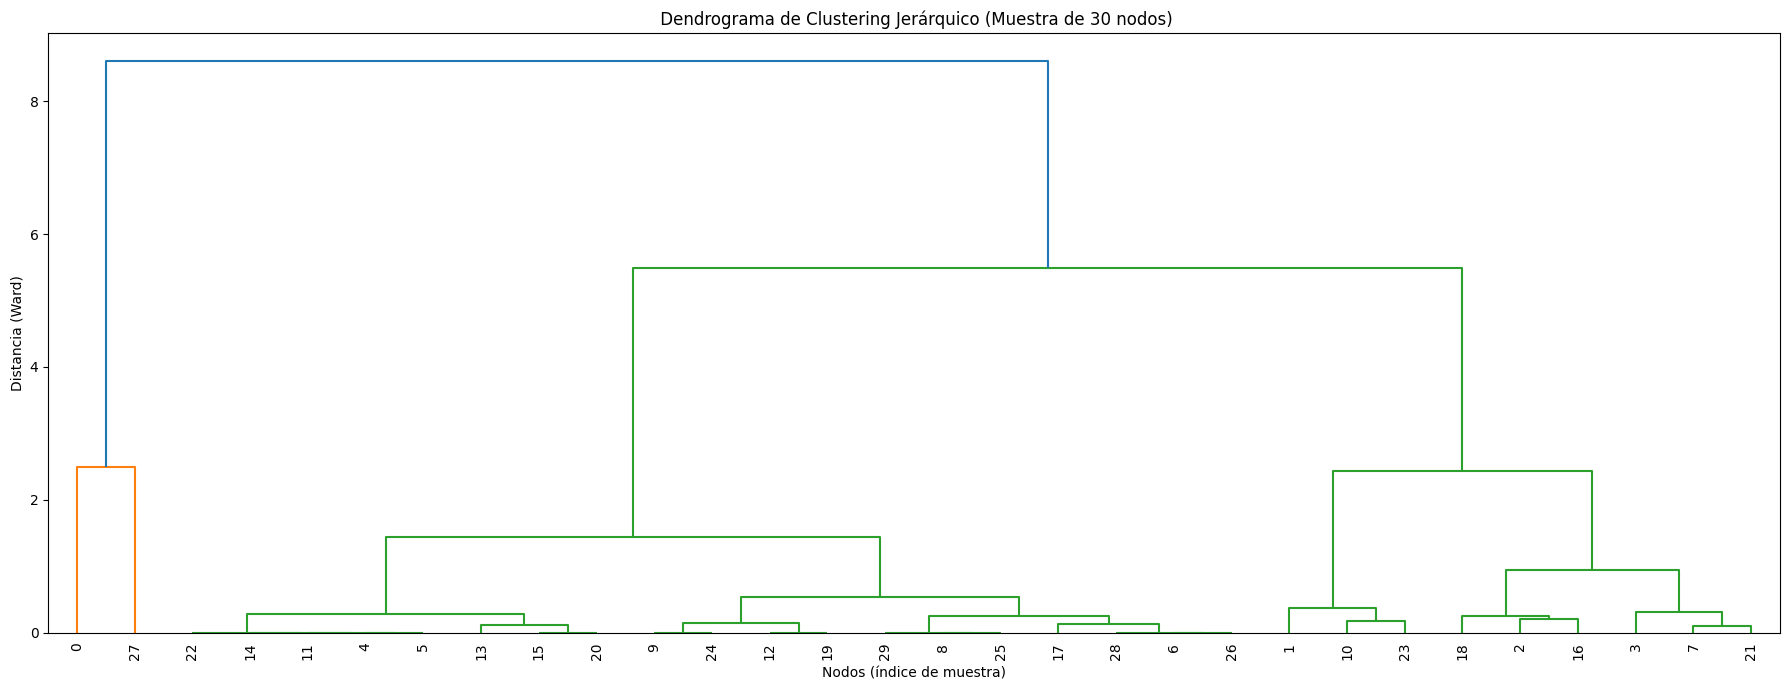

 Dendrograma (Matplotlib) guardado: /Users/janeth/Visual Modeling for Info/Checkpoint3/reports/figures/viz_dendrogram.png


In [140]:
# Usamos la matriz Z (linkage) que preparamos en la celda 2
plt.figure(figsize=(18, 7))
plt.title(' Dendrograma de Clustering Jerárquico (Muestra de 30 nodos)')
plt.xlabel('Nodos (índice de muestra)')
plt.ylabel('Distancia (Ward)')

dendrogram = sch.dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=10.,
)

dendrogram_path = os.path.join(FIG_DIR, "viz_dendrogram.png")
plt.tight_layout()
plt.savefig(dendrogram_path, dpi=140)
plt.show()

print(f" Dendrograma (Matplotlib) guardado: {dendrogram_path}")

###  Interpretación del Dendrograma

* **Clusters Naturales**: El dendrograma nos muestra los "clusters naturales" en los datos. Si cortamos el gráfico horizontalmente a una distancia alta (ej. `Distancia = 10`), podríamos obtener 2 o 3 grandes clusters (representados por los colores). Si cortamos más abajo (ej. `Distancia = 5`), obtenemos más clusters más pequeños.
* **Distancia de Fusión**: Las líneas verticales largas indican que se están fusionando clusters que son muy *diferentes* entre sí (ej. un nodo de grado alto con un nodo de grado bajo). Las líneas verticales cortas (cerca de la base) indican que se fusionan nodos muy *similares*.
* **Objetivo**: A diferencia del Treemap, este gráfico no muestra proporciones, sino **similitud**. Es una herramienta de exploración para decidir cuántos clusters "naturales" podríamos querer usar en un modelo de Machine Learning.

## Tabla Comparativa de Visualizaciones Jerárquicas

| Tipo de Gráfico | Propósito Principal | Ventajas | Limitaciones |
| :--- | :--- | :--- | :--- |
| **Treemap** | Mostrar proporciones de datos jerárquicos (Parte-del-Todo). | • Excelente para comparar el tamaño relativo de las categorías.<br>• Eficiente en el uso del espacio.<br>• Interactivo (Plotly). | • Difícil ver la profundidad de la jerarquía (más de 3 niveles se vuelve confuso).<br>• Las comparaciones de área no son tan precisas como un bar plot. |
| **Sunburst** | Mostrar la estructura y el flujo de la jerarquía. | • Muy bueno para ver la composición de los niveles (anillos).<br>• Visualmente atractivo e interactivo. | • Muy malo para comparar proporciones (los arcos externos son engañosamente grandes).<br>• Se vuelve ilegible con muchos niveles o categorías. |
| **Dendrograma** | Explorar clusters "naturales" basados en similitud (distancia). | • Basado en datos (Clustering Aglomerativo), no en categorías predefinidas.<br>• Ayuda a decidir el número óptimo de clusters (K). | • No muestra el tamaño o proporción de los clusters, solo la distancia de fusión.<br>• Ilegible para más de ~50 elementos. |


### 6. Recomendaciones y Conclusiones de la Fase 2

**Conclusión:**

La Fase 1 transformó las comunidades en una red, y la Fase 2 exploró la *estructura* de los nodos de esa red. Descubrimos que la red está dominada por nodos de bajo grado (cola larga), lo cual es típico. Las visualizaciones jerárquicas nos permitieron agrupar y entender estos nodos.

**Recomendaciones sobre Cuándo Usar Cada Tipo:**

* **Use un Treemap:** Cuando su pregunta sea: "¿Qué porcentaje de mis nodos de 'Grado Alto' también tienen un 'Grado Ponderado Alto'?" (Análisis de composición y proporción).

* **Use un Sunburst:** Cuando su pregunta sea: "¿Cómo se distribuyen mis nodos desde la categoría general (interna) hacia las subcategorías (externas)?" (Análisis de flujo y estructura).

* **Use un Dendrograma:** Cuando su pregunta sea: "No sé cuántos grupos de nodos tengo. ¿Cuántos clusters 'naturales' existen en mis datos basados en su grado y peso?" (Análisis exploratorio de clustering).

### 7. Gráficos para la visualización de Streamlit

In [141]:

import plotly.express as px
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

def plot_dendrogram(Z):
    """Genera y guarda el dendrograma usando la matriz de linkage Z (reutiliza código de celda abajo)."""
    # Reutiliza el mismo código que está más abajo, usa FIG_DIR global definido arriba
    plt.figure(figsize=(18, 7))
    plt.title(' Dendrograma de Clustering Jerárquico')
    plt.xlabel('Nodos (índice de muestra)')
    plt.ylabel('Distancia (Ward)')
    
    dendrogram = sch.dendrogram(
        Z,
        leaf_rotation=90.,
        leaf_font_size=10.,
    )
    
    dendrogram_path = os.path.join(FIG_DIR, "viz_dendrogram.png")
    plt.tight_layout()
    plt.savefig(dendrogram_path, dpi=140)
    plt.show()  # Mostrar en el notebook
    plt.close()
    
    print(f" Dendrograma (Matplotlib) guardado: {dendrogram_path}")

def plot_treemap(hierarchy_df):
    """Genera y guarda el treemap usando hierarchy_df (reutiliza estilo del código abajo)."""
    # Reutiliza FIG_DIR global definido arriba, similar a como se hace abajo con nodes_df
    # Agrupar por Root y size_group para el treemap
    treemap_data = hierarchy_df.groupby(['Root', 'size_group']).agg({'members_count': 'sum'}).reset_index()
    
    fig_treemap = px.treemap(
        treemap_data,
        path=[px.Constant("YouTube Communities"), 'Root', 'size_group'],
        values='members_count',
        color='members_count',
        color_continuous_scale='YlGnBu',
        title='Treemap de Comunidades por Tamaño'
    )
    
    fig_treemap.update_layout(margin=dict(t=50, l=25, r=25, b=25))
    
    treemap_path = os.path.join(FIG_DIR, "viz_treemap_multi_level.png")
    fig_treemap.write_image(treemap_path)
    fig_treemap.show()  # Mostrar en el notebook
    
    print(f" Treemap (Plotly) guardado: {treemap_path}")

def plot_sunburst_approximation(hierarchy_df):
    """Genera y guarda el sunburst usando hierarchy_df mostrando porcentajes."""
    # Reutiliza FIG_DIR global definido arriba, similar a como se hace abajo con treemap_data
    # Agrupar por Root y size_group para el sunburst
    sunburst_data = hierarchy_df.groupby(['Root', 'size_group']).agg({'members_count': 'sum'}).reset_index()
    
    # Calcular porcentajes
    total = sunburst_data['members_count'].sum()
    sunburst_data['percentage'] = (sunburst_data['members_count'] / total * 100).round(2)
    
    # Crear etiquetas con porcentajes
    sunburst_data['label'] = sunburst_data['size_group'] + '<br>' + sunburst_data['percentage'].astype(str) + '%'
    
    fig_sunburst = px.sunburst(
        sunburst_data,
        path=['Root', 'size_group'],
        values='members_count',
        color='members_count',
        color_continuous_scale='Blues',  # Paleta de azules
        title='Sunburst de Comunidades por Tamaño',
        labels={'members_count': 'Miembros', 'size_group': 'Tamaño de Comunidad'}
    )
    
    # Actualizar texto para mostrar solo porcentaje del total en las etiquetas
    # El centro solo mostrará "Comunidades de YouTube" sin porcentaje (Plotly no muestra % en el root)
    fig_sunburst.update_traces(
        texttemplate='%{label}<br>%{percentEntry:.1%}',
        textinfo='label+percent entry',
        insidetextorientation='radial',
        hovertemplate='<b>%{label}</b><br>Miembros: %{value:,.0f}<br>Porcentaje del total: %{percentEntry:.1%}<extra></extra>'
    )
    
    fig_sunburst.update_layout(margin=dict(t=50, l=25, r=25, b=25))
    
    sunburst_path = os.path.join(FIG_DIR, "viz_sunburst_multi_level.png")
    fig_sunburst.write_image(sunburst_path)
    fig_sunburst.show()  # Mostrar en el notebook
    
    print(f" Sunburst (Plotly) guardado: {sunburst_path}")

print(" Funciones de visualización definidas: plot_dendrogram, plot_treemap, plot_sunburst_approximation")


 Funciones de visualización definidas: plot_dendrogram, plot_treemap, plot_sunburst_approximation


Matriz Z cargada desde archivo. Fusiones: 99
 Jerarquía Treemap cargada desde archivo. Filas: 7336

--- Generando Gráficos ---


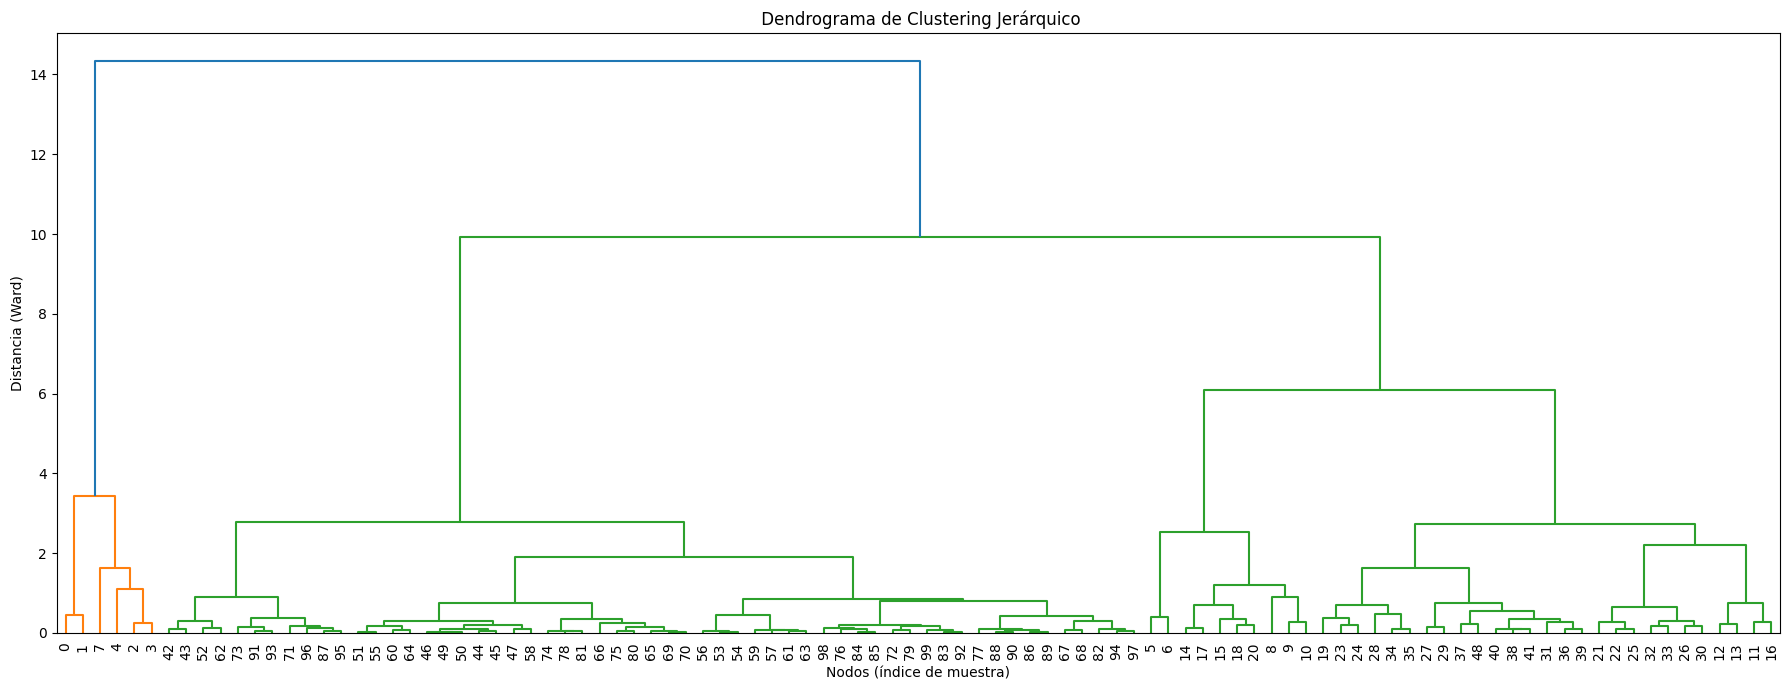

 Dendrograma (Matplotlib) guardado: /Users/janeth/Visual Modeling for Info/Checkpoint3/reports/figures/viz_dendrogram.png


 Treemap (Plotly) guardado: /Users/janeth/Visual Modeling for Info/Checkpoint3/reports/figures/viz_treemap_multi_level.png


 Sunburst (Plotly) guardado: /Users/janeth/Visual Modeling for Info/Checkpoint3/reports/figures/viz_sunburst_multi_level.png

 Finalizada la generación de visualizaciones.


In [142]:

try:
    from sklearn.preprocessing import StandardScaler
except ImportError:
    print(" sklearn no disponible. Instala con: pip install scikit-learn")

LINKAGE_MATRIX_PATH = os.path.join(PROC_DIR, "linkage_matrix.npy")
HIERARCHY_TREEMAP_PATH = os.path.join(PROC_DIR, "hierarchy_treemap.csv")

# 1. Cargar o generar matriz de linkage Z
try:
    Z = np.load(LINKAGE_MATRIX_PATH)
    print(f"Matriz Z cargada desde archivo. Fusiones: {Z.shape[0]}")
except FileNotFoundError:
    # Si no existe, intentar generar Z desde nodes_df (si está disponible)
    try:
        nodes_path = os.path.join(PROC_DIR, "youtube_nodes.csv")
        nodes_df = pd.read_csv(nodes_path)
        sample_df = nodes_df.sample(n=30, random_state=1)
        scaler = StandardScaler()
        sample_scaled = scaler.fit_transform(sample_df[['degree', 'weighted_degree']])
        Z = sch.linkage(sample_scaled, method='ward')
        # Guardar Z para futuras ejecuciones
        np.save(LINKAGE_MATRIX_PATH, Z)
        print(f" Matriz Z generada y guardada. Fusiones: {Z.shape[0]}")
    except Exception as e:
        print(f" No se pudo generar Z: {e}")
        Z = None

# 2. Cargar o generar jerarquía treemap
try:
    hierarchy_df = pd.read_csv(HIERARCHY_TREEMAP_PATH)
    print(f" Jerarquía Treemap cargada desde archivo. Filas: {len(hierarchy_df)}")
except FileNotFoundError:
    # Si no existe, intentar generar desde clean_no_outliers.csv
    try:
        clean_no_out_path = os.path.join(PROC_DIR, "youtube_clean_no_outliers.csv")
        clean_df = pd.read_csv(clean_no_out_path)
        
        def size_group(size):
            if size >= 15:
                return "Big (>=15 people)"
            elif size >= 8:
                return "Medium (8-14 people)"
            else:
                return "Small (3-7 people)"
        
        df = clean_df.copy()
        df["size_group"] = df["size_cleaned"].apply(size_group)
        df["Root"] = "YouTube_Communities"
        hierarchy_df = df.groupby(["Root", "size_group", "community_id"])["size_cleaned"].sum().reset_index(name="members_count")
        # Guardar para futuras ejecuciones
        hierarchy_df.to_csv(HIERARCHY_TREEMAP_PATH, index=False)
        print(f" Jerarquía Treemap generada y guardada. Filas: {len(hierarchy_df)}")
    except Exception as e:
        print(f" No se pudo generar hierarchy_treemap: {e}")
        hierarchy_df = None

# 3. Ejecutar visualizaciones si tenemos los datos
if Z is not None and hierarchy_df is not None:
    print("\n--- Generando Gráficos ---")
    
    # 1. Dendrograma
    plot_dendrogram(Z)
    
    # 2. Treemap
    plot_treemap(hierarchy_df)
    
    # 3. Sunburst
    plot_sunburst_approximation(hierarchy_df)
    
    print("\n Finalizada la generación de visualizaciones.")
else:
    print("\n No se pueden generar las visualizaciones. Faltan archivos necesarios.")
    print("   Asegúrate de ejecutar primero las celdas que generan:")
    print("   - youtube_nodes.csv (para Z)")
    print("   - youtube_clean_no_outliers.csv (para hierarchy_treemap)")


## 1. Dendrograma de Clustering Jerárquico

### Descripción de la Gráfica

El dendrograma es un gráfico en forma de árbol que visualiza las relaciones jerárquicas y las distancias de similitud entre los nodos (individuos o cuentas) de la red.

- **Eje Y ("Distancia (Ward)")**: Representa la disimilitud entre los clusters. Cuanto más alta es la línea horizontal que une dos ramas, mayor es la distancia (menor la similitud) entre los grupos que se fusionan.
- **Eje X ("Nodos (índice de muestra)")**: Muestra los índices de los nodos individuales en la red.
- **Estructura**: Múltiples ramas que se fusionan progresivamente, revelando grupos naturales de contactos con características similares.

### Utilidad para Ana Sofía

1. **Identificación de Grupos Naturales**
   - Permite visualizar cómo se agrupan naturalmente los contactos
   - Identifica segmentos de audiencia que comparten características o comportamientos similares, incluso si no están directamente conectados
   - Facilita la segmentación avanzada más allá de métricas superficiales

2. **Estrategias de Contenido Personalizado**
   - Al entender qué contactos son más similares, puede crear mensajes y campañas altamente personalizados
   - Aumenta la efectividad del alcance al resonar con grupos específicos
   - Optimiza la personalización de mensajes para cada segmento

3. **Detección de Influencers Clave y Outliers**
   - Un nodo que se une al resto de la red a una distancia muy alta podría ser un "outlier" o un influencer con un perfil único
   - Indica oportunidades para estrategias de engagement muy específicas
   - Ayuda a entender nichos de mercado particulares

4. **Base para la Segmentación Avanzada**
   - Ofrece una base visual para la segmentación de la audiencia
   - Permite una comprensión más profunda de la estructura social de la red
   - Facilita la toma de decisiones basada en similitudes reales, no solo conexiones directas

---

## 2. Treemap de Comunidades por Tamaño

### Descripción de la Gráfica

El treemap representa la distribución jerárquica de las comunidades en la red, mostrando el número absoluto de miembros en cada categoría de tamaño (Pequeñas, Medianas, Grandes). Cada rectángulo anidado representa una comunidad o un grupo de comunidades, y su tamaño es proporcional al número de miembros.

- **Comunidades Pequeñas (3-7 personas)**: Rectángulo más grande, color azul oscuro
- **Comunidades Medianas (8-14 personas)**: Rectángulo mediano, color azul medio
- **Comunidades Grandes (≥15 personas)**: Rectángulo más pequeño, color azul claro
- **Escala de Color**: La intensidad del color indica la concentración de miembros

### Utilidad para Ana Sofía

1. **Visión General de la Composición de la Red**
   - Ofrece una instantánea clara de cuántos miembros se encuentran en comunidades de diferentes tamaños
   - Permite ver rápidamente si la mayoría de su audiencia está en comunidades pequeñas y nicho, o en grandes grupos de difusión masiva
   - Simplifica la comprensión de datos complejos

2. **Asignación Estratégica de Recursos**
   - **Comunidades Pequeñas (3-7 personas)**: 
     - Ideales para el engagement profundo y personalizado
     - Invertir en relaciones uno a uno, co-creación de contenido y fomento de la lealtad
     - Herramientas para outreach personalizado
   
   - **Comunidades Medianas (8-14 personas)**:
     - Oportunidades para campañas focalizadas
     - Identificación de líderes de opinión emergentes
     - Fomento de la colaboración
     - Testing de contenido antes de un rollout más amplio
   
   - **Comunidades Grandes (≥15 personas)**:
     - Perfectas para la difusión masiva de contenido
     - Identificación de macro-influencers
     - Análisis de tendencias generales
     - Campañas de alto impacto

3. **Equilibrio de Tácticas**
   - Ayuda a decidir si debe centrarse en la personalización intensiva o en el alcance masivo
   - El treemap proporciona la información visual para tomar esa decisión estratégica
   - Optimiza la asignación de tiempo, presupuesto y esfuerzos de creación de contenido

4. **Identificación de Segmentos Dominantes**
   - Resalta visualmente qué tamaños de comunidad son los más prevalentes
   - Indica dónde podría estar la mayor parte de su audiencia o influencia
   - Facilita la identificación de oportunidades de crecimiento

---

## 3. Sunburst de Comunidades por Tamaño (con Porcentajes)

### Descripción de la Gráfica

El sunburst es un gráfico circular multi-nivel que visualiza la jerarquía de las comunidades por tamaño, mostrando la distribución proporcional de los miembros. El centro del gráfico representa "Comunidades de YouTube", y los anillos externos se dividen en segmentos que representan los grupos de tamaño (Pequeñas, Medianas, Grandes), mostrando el porcentaje del total de miembros que pertenecen a cada uno. Utiliza una paleta de colores azules.

- **Centro (Raíz)**: "Comunidades de YouTube" (100.0%) - punto de partida de la jerarquía
- **Anillo Exterior**: 
  - **Pequeñas (3-7)**: ~52.4% - segmento más grande, azul oscuro
  - **Medianas (8-14)**: ~31.2% - azul medio
  - **Grandes (≥15)**: ~16.4% - segmento más pequeño, azul claro

### Utilidad para Ana Sofía

1. **Distribución Proporcional Clara**
   - A diferencia del treemap que muestra el tamaño absoluto, el sunburst enfatiza la proporción
   - Permite ver de inmediato, por ejemplo, que "el 52.4% de los miembros están en comunidades pequeñas"
   - Es crucial para entender la composición relativa de la audiencia

2. **Comprensión Intuitiva de la Jerarquía**
   - La estructura anidada del sunburst (del centro hacia afuera) facilita la comprensión de cómo se desglosa la red total
   - El formato circular es más intuitivo para visualizar proporciones que gráficos lineales
   - Los porcentajes directos en las etiquetas facilitan la interpretación inmediata

3. **Toma de Decisiones Basada en Proporciones**
   - Si un gran porcentaje de la red se encuentra en comunidades grandes, Ana Sofía podría priorizar estrategias de contenido viral o campañas de amplio alcance
   - Si un porcentaje significativo está en comunidades pequeñas, podría enfocarse en micro-influencers y engagement directo
   - Facilita la priorización estratégica basada en la distribución real

4. **Complemento al Treemap**
   - Juntos, el treemap y el sunburst ofrecen una visión completa:
     - **Treemap**: Para el volumen absoluto y la concentración de miembros
     - **Sunburst**: Para la proporción y distribución relativa
   - Permite una estrategia de marketing más holística y basada en datos
   - Facilita la comunicación de insights a stakeholders

5. **Mensaje Centralizado**
   - El centro del sunburst, etiquetado como "Comunidades de YouTube", sirve como un punto de referencia claro para el contexto de la red analizada
   - Facilita la comprensión del contexto general antes de analizar los detalles

---

## Resumen: Estrategia Integral para el Dashboard

Estas tres visualizaciones en el dashboard de Streamlit equipan a Ana Sofía con herramientas poderosas para:

1. **Segmentar su audiencia** de manera inteligente (Dendrograma)
   - Identifica grupos naturales basados en similitudes reales
   - Facilita la personalización de mensajes y campañas

2. **Comprender la escala y el volumen** de sus comunidades (Treemap)
   - Visualiza la concentración absoluta de miembros
   - Optimiza la asignación de recursos por tamaño de comunidad

3. **Visualizar la distribución proporcional** de su red (Sunburst)
   - Entiende qué porcentaje de su audiencia está en cada tipo de comunidad
   - Toma decisiones estratégicas basadas en proporciones

### Beneficios Estratégicos Combinados

- **Pasar de una estrategia genérica a una altamente dirigida**: Las visualizaciones revelan patrones que no serían evidentes en tablas de datos
- **Maximizar el impacto de conexiones y mensajes**: Al entender la estructura real de la red, puede optimizar dónde y cómo invertir sus esfuerzos
- **Tomar decisiones basadas en datos**: En lugar de intuición, tiene evidencia visual clara de la composición de su red
- **Comunicar insights efectivamente**: Las visualizaciones facilitan la comunicación de estrategias a equipos y stakeholders

### Aplicación Práctica

Para Ana Sofía, estas visualizaciones se traducen en:

- **Estrategias de contenido** diferenciadas por tipo de comunidad
- **Asignación de presupuesto** optimizada según el tamaño y proporción de comunidades
- **Identificación de oportunidades** de crecimiento y engagement
- **Validación de hipótesis** sobre la composición de su audiencia
- **Recomendaciones accionables** para maximizar el ROI de sus campañas de marketing digital

En esencia, estas visualizaciones transforman datos complejos de red en información estratégica clara y accionable, permitiendo a Ana Sofía Mendoza optimizar sus conexiones profesionales y maximizar el impacto medible de sus campañas de marketing digital.